In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.special as ssp
import sys
import scipy.io as sio
sys.path.append("../code/")
from pi_vae import *
from util import *
from keras.callbacks import ModelCheckpoint

## import plot packages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker

%load_ext autoreload
%autoreload 2
%matplotlib inline

## load rat data

In [2]:
## load data
rat_data = sio.loadmat("../data/achilles_data/Achilles_data.mat")

In [3]:
## load trial information
idx_split = rat_data['trial'][0]
## load spike data
spike_by_neuron_use = rat_data['spikes']
## load locations
locations_vec = rat_data['loc'][0]
## load lfp
tlfp_vec = rat_data['lfp'][0]

In [4]:
u_all = np.array(np.array_split(np.hstack((locations_vec.reshape(-1,1),np.zeros((locations_vec.shape[0],2)))), idx_split[1:-1], axis=0))
x_all = np.array(np.array_split(spike_by_neuron_use, idx_split[1:-1], axis=0))
for ii in range(len(u_all)):
    u_all[ii][:,int(ii%2)+1] = 1;
    
trial_ls = np.arange(len(u_all));
np.random.seed(666);
random_ls = np.random.permutation(trial_ls);

In [5]:
u_train = u_all[trial_ls[:68]];
x_train = x_all[trial_ls[:68]];

u_valid = u_all[trial_ls[68:76]];
x_valid = x_all[trial_ls[68:76]];

u_test = u_all[trial_ls[76:]];
x_test = x_all[trial_ls[76:]];

In [6]:
## fit pca
from sklearn.decomposition import PCA
pca_raw = PCA(n_components=2);
pca_raw_rlt = pca_raw.fit_transform(np.concatenate(x_all));

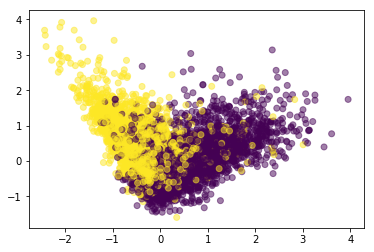

In [7]:
## plot pca results
plt.scatter(pca_raw_rlt[:,0], pca_raw_rlt[:,1], alpha=0.5, c=(np.concatenate(u_all)[:,-1]>0))

## fit pi-vae

In [8]:
vae = vae_mdl(dim_x=x_all[0].shape[-1], 
                   dim_z=2,
                   dim_u=u_all[0].shape[-1], 
                   gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4)

Instructions for updating:
Colocations handled automatically by placer.
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 22668       input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Model)         

/home/dz2336/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  'be expecting any data to be passed to {0}.'.format(name))
/home/dz2336/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


# use pi-vae_rat_data_try_different_random_seed.py to run all the random seeds and load the results to check here

In [9]:
seed_vec = [111,222,333,444,555,666,777,888,999,1000,1100,1200]
elbo_samples_all = np.zeros((100, len(seed_vec)))
for i in range(len(seed_vec)):
    seed_use = seed_vec[i]
    elbo_samples_all[:,i] = np.load('../results/rat_2d_'+str(seed_use)+'_pivae_elbo_samples.npy')

Text(0.5,0,'random seeds')

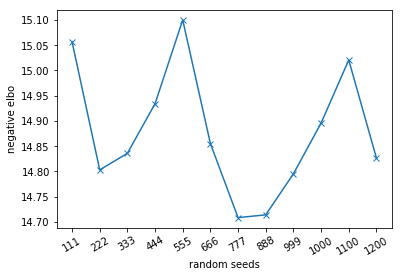

In [12]:
plt.plot(elbo_samples_all.mean(axis=0),'-x')
plt.xticks(np.arange(len(seed_vec)), seed_vec, rotation = 30);
plt.ylabel('negative elbo')
plt.xlabel('random seeds')

/home/dz2336/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


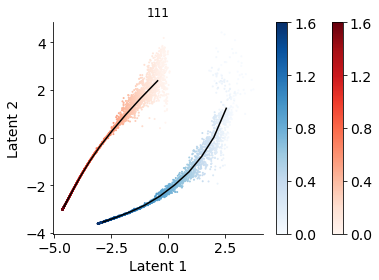

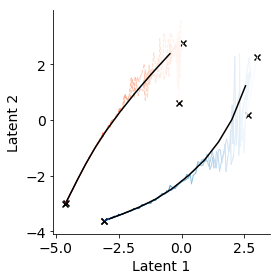

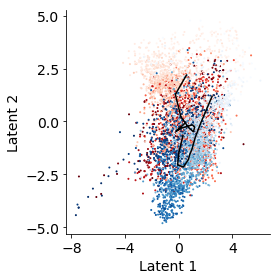

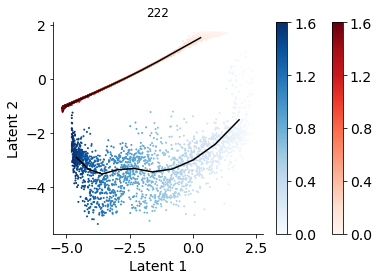

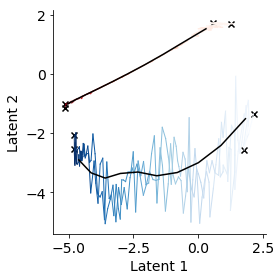

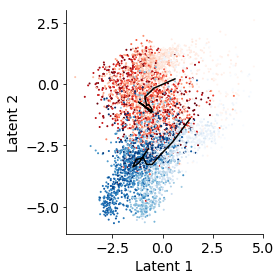

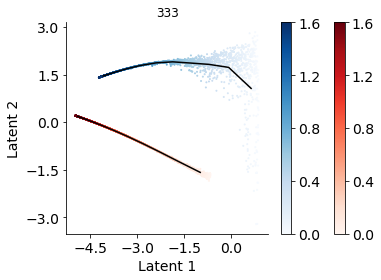

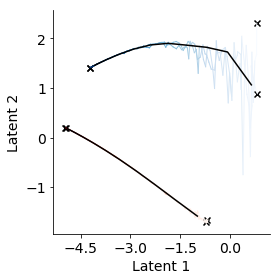

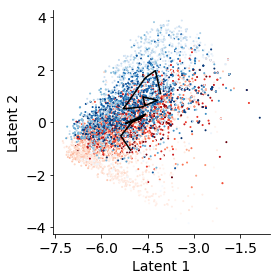

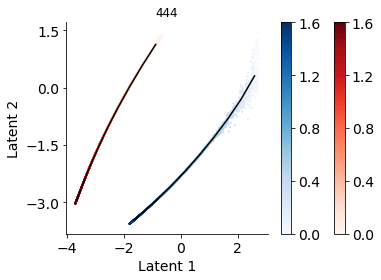

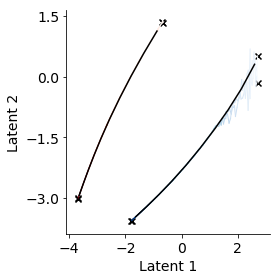

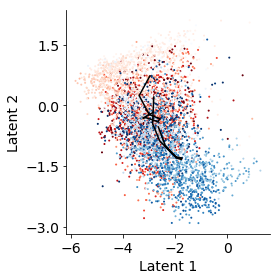

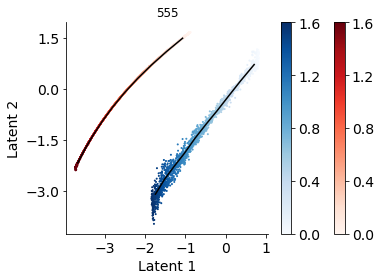

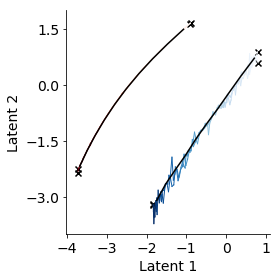

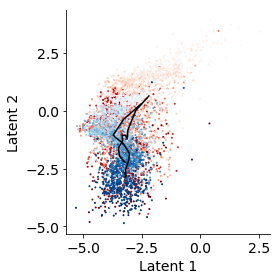

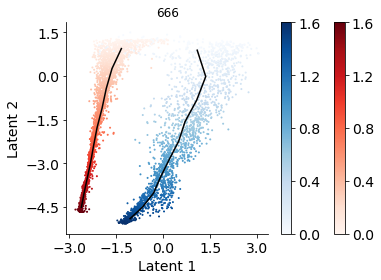

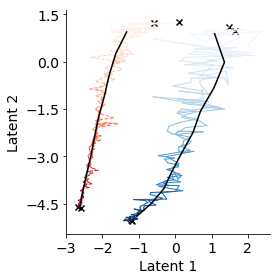

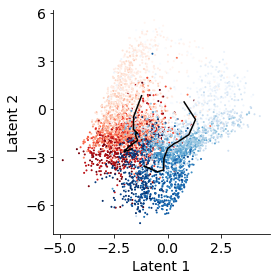

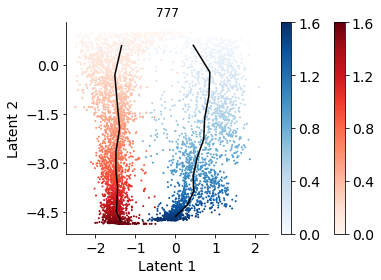

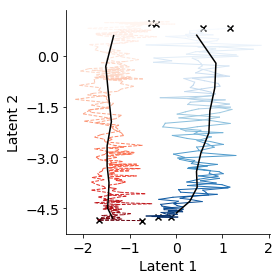

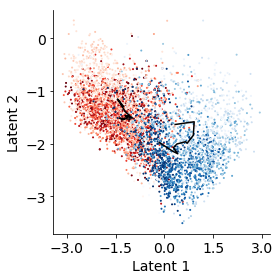

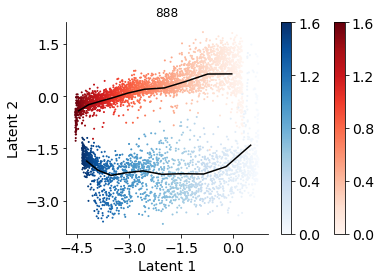

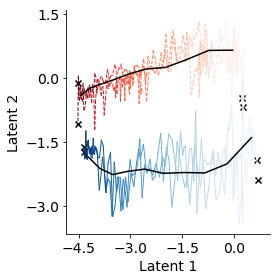

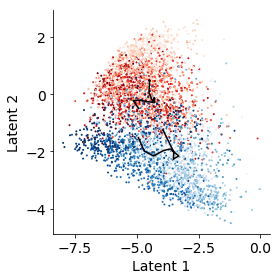

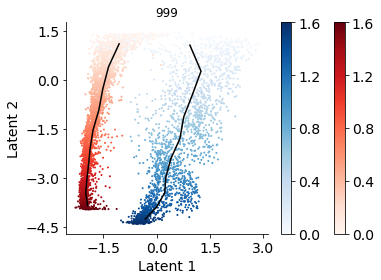

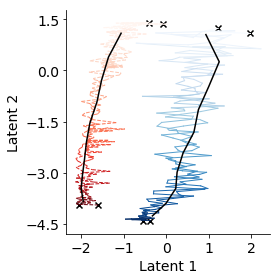

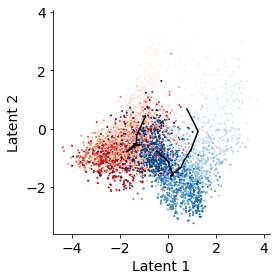

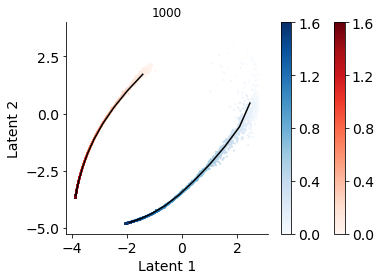

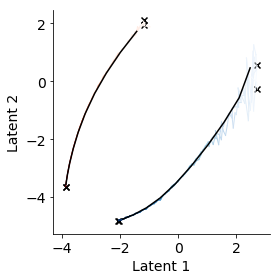

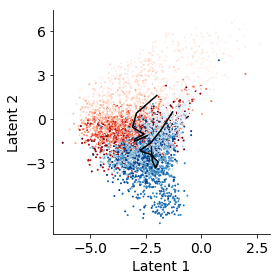

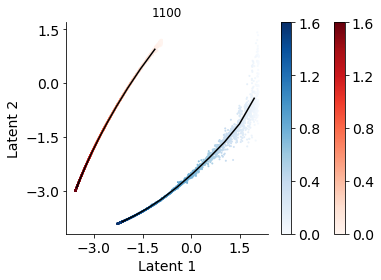

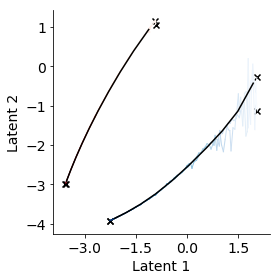

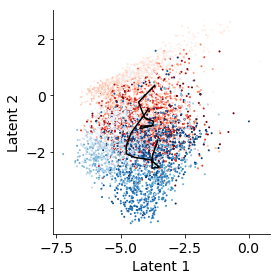

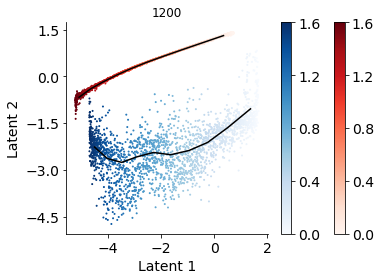

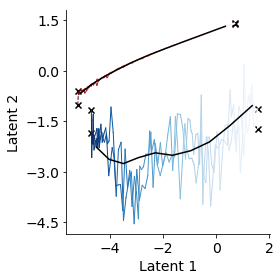

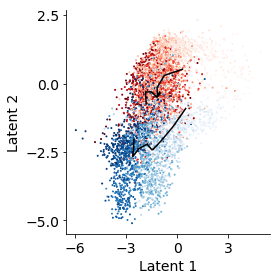

In [11]:
seed_vec = [111,222,333,444,555,666,777,888,999,1000,1100,1200]
def get_tc_rd(y, hd, hd_bins): # compute empirical tunning curve of data
    tuning_curve = np.zeros((len(hd_bins)-1, y.shape[1]));
    for ii in range(len(hd_bins)-1):
        data_pos = ((hd>=hd_bins[ii])*(hd<=hd_bins[ii+1]));
        tuning_curve[ii,:] = y[data_pos,:].mean(axis=0);
    return tuning_curve
for i in range(len(seed_vec)):
    seed_use = seed_vec[i]
    np.random.seed(seed_use);
    
    model_chk_path = '../results/rat_2d_'+str(seed_use)+'_pivae.h5' ##999, 777
    vae.load_weights(model_chk_path);
    outputs = vae.predict_generator(custom_data_generator(x_all, u_all),
                                                steps = len(x_all));
    # post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var

    z_pred_all = [];
    for ii in range(len(x_all)):
        z_pred_all.append(vae.predict([x_all[ii], u_all[ii]])[0][:,:]);
    z_pred_all = np.array(z_pred_all);

    ## posterior mean

    ll = 11;
    hd_bins = np.linspace(0,1.6,ll);
    select = (np.concatenate(u_all)[:,1]==1);
    tc1 = get_tc_rd(outputs[0][select], np.concatenate(u_all)[select,0], hd_bins);
    select = (np.concatenate(u_all)[:,2]==1);
    tc2 = get_tc_rd(outputs[0][select], np.concatenate(u_all)[select,0], hd_bins);

    dis_mat = np.zeros((len(tc1), len(tc2)));
    for jj in range(len(tc1)):
        dis_mat[jj] = np.sqrt(np.square(tc1[jj]-tc2).sum(axis=-1))

    ll = 5000;
    fig = plt.figure(figsize=(5.5,4))
    ax = plt.subplot(111); #fig.add_subplot(111, projection='3d')
    ax.set_title(seed_use)
    fsz = 14;
    ## learn locations
    select = (np.concatenate(u_all)[:ll,1]==1);

    im = ax.scatter(outputs[0][:ll][select][:,0], outputs[0][:ll][select][:,1],s=1,c=np.concatenate(u_all)[:ll][select,0],
               cmap='Reds',vmin=0,vmax=1.6);
    ax.plot(tc1[:,0],tc1[:,1],c='black');
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=14) 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    ## learn locations
    select = (np.concatenate(u_all)[:ll][:,1]==0);

    im = ax.scatter(outputs[0][:ll][select][:,0], outputs[0][:ll][select][:,1],s=1,c=np.concatenate(u_all)[:ll][select,0],
               cmap='Blues',vmin=0,vmax=1.6);
    ax.plot(tc2[:,0],tc2[:,1],c='black');
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=14) 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    ax.set_xlabel('Latent 1', fontsize=fsz);
    ax.set_ylabel('Latent 2', fontsize=fsz);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=fsz);
    plt.setp(ax.get_yticklabels(), fontsize=fsz);

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))

    plt.tight_layout()
    
    ## posterior mean single trial trajectory

    ndim = 0;
    ll = 20;
    fsz = 14;
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    bins = np.linspace(np.concatenate(u_all)[:,ndim].min(),np.concatenate(u_all)[:,ndim].max(),ll);
    centers = (bins[1:]+bins[:-1])/2;
    lines = ['--', '-']
    for ii in range(4):
        length = len(z_pred_all[ii]);
        disc_loc = np.digitize(u_all[ii][:,ndim],centers);
        if ii%2:
            c_vec = plt.cm.Blues(np.linspace(0,1,ll))#[::-1];
        else:
            c_vec = plt.cm.Reds(np.linspace(0,1,ll))#[::-1];

        c_all = c_vec[disc_loc];
        ax.scatter(z_pred_all[ii][0,0], z_pred_all[ii][0,1], marker='x',c='black')
        for jj in range(length-1):
            tmp = np.linspace(z_pred_all[ii][jj], z_pred_all[ii][jj+1], 10);
            ax.plot(tmp[:,0], tmp[:,1], lines[ii%2], c=c_all[jj], linewidth=1);
        ax.scatter(z_pred_all[ii][-1,0], z_pred_all[ii][-1,1],marker='x',c='black')
    ax.plot(tc1[:,0],tc1[:,1],c='black');
    ax.plot(tc2[:,0],tc2[:,1],c='black');
    ax.set_xlabel('Latent 1', fontsize=fsz);
    ax.set_ylabel('Latent 2', fontsize=fsz);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=fsz);
    plt.setp(ax.get_yticklabels(), fontsize=fsz);

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))
    plt.tight_layout()
    
    ## posterior mean w/o prior

    ll = 11;
    hd_bins = np.linspace(0,1.6,ll);
    select = (np.concatenate(u_all)[:,1]==1);
    tc1 = get_tc_rd(outputs[6][select], np.concatenate(u_all)[select,0], hd_bins);
    select = (np.concatenate(u_all)[:,2]==1);
    tc2 = get_tc_rd(outputs[6][select], np.concatenate(u_all)[select,0], hd_bins);

    dis_mat_no_pri = np.zeros((len(tc1), len(tc2)));
    for jj in range(len(tc1)):
        dis_mat_no_pri[jj] = np.sqrt(np.square(tc1[jj]-tc2).sum(axis=-1))

    ll = 5000;
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111); #fig.add_subplot(111, projection='3d')
    fsz = 14;
    ## learn locations
    select = (np.concatenate(u_all)[:ll,1]==1);
    length = 20;
    c_vec = plt.cm.Reds(np.linspace(0,1,length))
    bins = np.linspace(0,1.6,length);
    centers = (bins[1:]+bins[:-1])/2;
    disc_loc = np.digitize(np.concatenate(u_all)[:ll][select,0],centers);
    c_all = c_vec[disc_loc];

    ax.scatter(outputs[6][:ll][select][:,0], outputs[6][:ll][select][:,1],s=1,c=c_all);
    ax.plot(tc1[:,0],tc1[:,1],c='black');
    ## learn locations
    select = (np.concatenate(u_all)[:ll][:,1]==0);
    length = 20;
    c_vec = plt.cm.Blues(np.linspace(0,1,length))
    bins = np.linspace(0,1.6,length);
    centers = (bins[1:]+bins[:-1])/2;
    disc_loc = np.digitize(np.concatenate(u_all)[:ll][select,0],centers);
    c_all = c_vec[disc_loc];

    ax.scatter(outputs[6][:ll][select][:,0], outputs[6][:ll][select][:,1],s=1,c=c_all);
    ax.plot(tc2[:,0],tc2[:,1],c='black');
    ax.set_xlabel('Latent 1', fontsize=fsz);
    ax.set_ylabel('Latent 2', fontsize=fsz);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=fsz);
    plt.setp(ax.get_yticklabels(), fontsize=fsz);

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4,min_n_ticks=4,prune=None))

    plt.tight_layout()